# Filters

Animated visualizers of filters.

In [1]:
%matplotlib inline

import time

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_combined, sim_cycle
from neurodsp.plts import plot_time_series
from neurodsp.utils import create_samples, set_random_seed
from neurodsp.filt.fir import design_fir_filter, apply_fir_filter
from neurodsp.filt.utils import compute_frequency_response, remove_filter_edges
from neurodsp.plts.filt import plot_filter_properties, plot_frequency_response, plot_impulse_response

In [2]:
# Import local code
from vcode.utils.data import incrementer
from vcode.plts.utils import clear_output, animate_plot
from vcode.plts.base import plot_data
from vcode.measures.convolution import compute_convolution
from vcode.build.convolution import build_convolution
from vcode.build.filt import build_filter_properties, build_filter_ouput

## Setup

### Settings

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
# Set random seed
set_random_seed(505)

In [5]:
# Signal settings
fs = 250
n_seconds = 1.5

In [6]:
# Save settings
SAVE = False

## Filter

### Design a Filter

In [7]:
# Filter settings
pass_type = 'bandpass'
f_range = (8, 12)

In [8]:
# Create the filter kernel
filt_coefs = design_fir_filter(fs, pass_type, f_range)
samps = create_samples(len(filt_coefs))

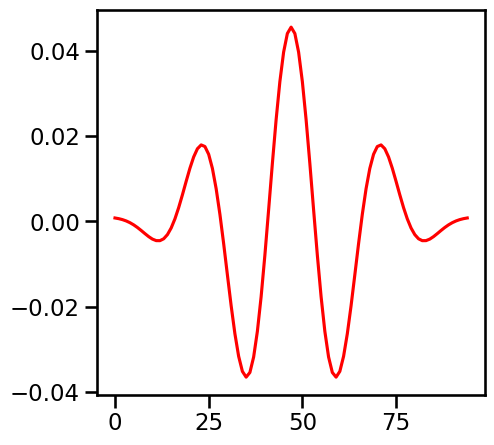

In [9]:
# Plot the filter kernel
plot_data(filt_coefs, color='red')

### Compare Convolution

Double check that our custom convolution matches what we get from applying the filter normally. 

In [10]:
# Define an example signal
comps = {'sim_oscillation' : {'freq' : 10}, 
         'sim_powerlaw' : {'exponent' : -1, 'f_range' : (1, None)}}
sig = sim_combined(n_seconds, fs, comps)

In [11]:
# Apply the standard filter function & custom convolution function, to compare
standard = apply_fir_filter(sig, filt_coefs)
standard = remove_filter_edges(standard, len(filt_coefs))
custom = compute_convolution(sig, filt_coefs)

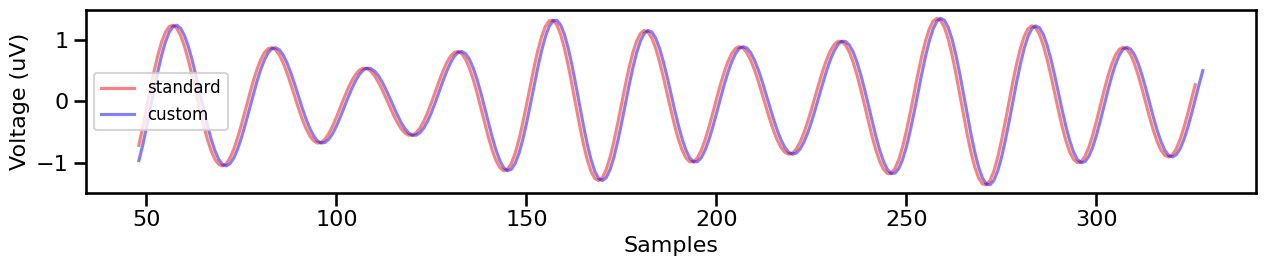

In [12]:
# Plot filtered traces, comparing custom to standard
plot_time_series(None, [standard, custom], labels=['standard', 'custom'],
                 colors=['red', 'blue'], alpha=0.5, figsize=(13, 3))

Note: based on the heuristic of which sample to start at, there can be an off-by-one difference of where the filter gets applied. 

Otherwise, we can see in the above that the output generally matches.

## Convolution Animations

Animations of applying filters, based on showing the convolution.

### Combined Signal

Visualize filter on a combined signal (a signal with an aperiodic + periodic component). 

In [13]:
# Simulate a combined signal
comps = {'sim_oscillation' : {'freq' : 10}, 
         'sim_powerlaw' : {'exponent' : -1, 'f_range' : (1, None)}}
sig = sim_combined(n_seconds, fs, comps)

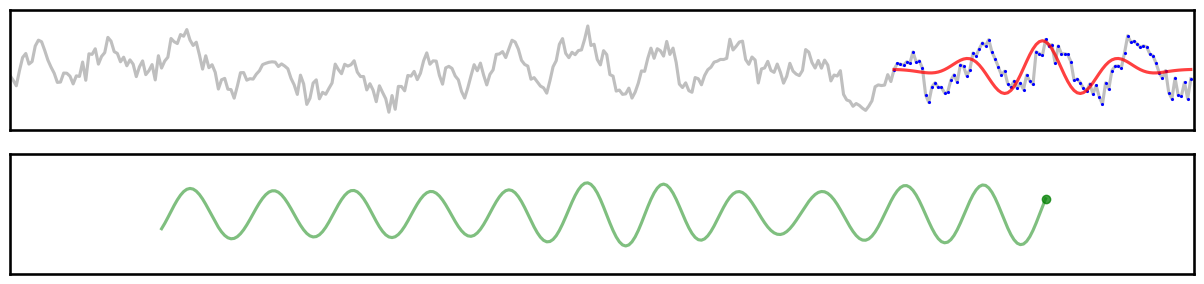

In [14]:
# Run the filter viz
build_convolution(sig, filt_coefs*1.5, sleep=0.01, save=SAVE, label='04-filter_comb_sig')

In [15]:
## OLD - TEST

In [16]:
# for ind in range(0, 1000, 10):
#     clear_output(wait=True)
#     _, ax = plt.subplots(figsize=[12, 2])
#     plot_time_series(None, sig, alpha=0.5, ax=ax)
#     plot_time_series(samps+ind, sig[samps+ind], marker='.', markersize=2, linewidth=0, colors='blue', ax=ax)
#     plot_time_series(samps+ind, filt_coefs * 100, colors='red', ax=ax)
#     ax.set(xticks=[], yticks=[], xlabel='', ylabel='');
#     plt.show();
#     time.sleep(0.25)

### Impulse Response

Visualize filter on an impulse response (a signal of zeros with a single 1-valued data point). 

In [17]:
# Create an impulse response
impulse_sig = np.zeros_like(sig)
impulse_sig[int(len(impulse_sig) / 2)] = 1

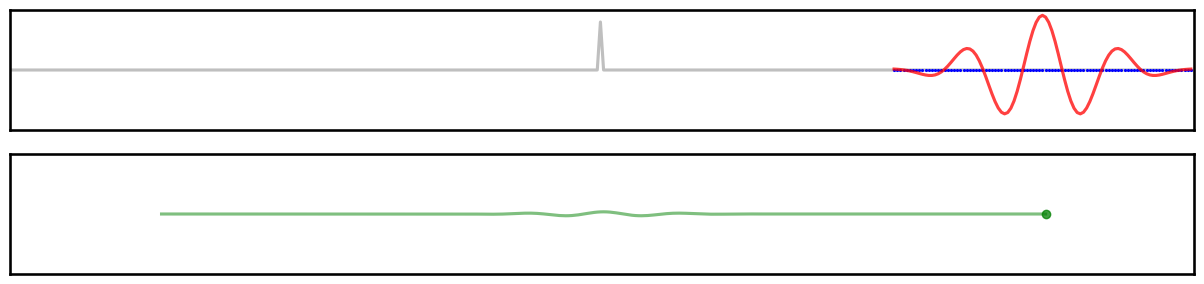

In [18]:
# Run the filter viz
build_convolution(impulse_sig, filt_coefs, ylim=[-1.25, 1.25],
                  save=SAVE, label='04-filter_impulse_response')

### Step Response

Visualize filter on a step signal (a signal of zeros that then 'steps' to a value of 1).

In [19]:
# Create a step signal
step_sig = np.zeros_like(sig)
step_sig[int(len(impulse_sig) / 2):] = 1

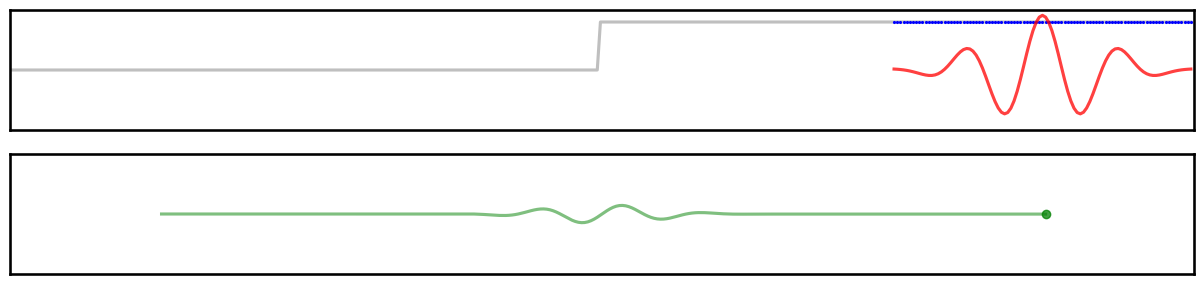

In [20]:
# Run the filter viz
build_convolution(step_sig, filt_coefs, ylim=[-1.25, 1.25],
                  save=SAVE, label='04-filter_step')

### Aperiodic Signal

Visualize filter on an aperiodic signal.

In [21]:
# Simulate a purely aperiodic signal
sig = sim_powerlaw(n_seconds, fs, exponent=-1., f_range=(1, None))

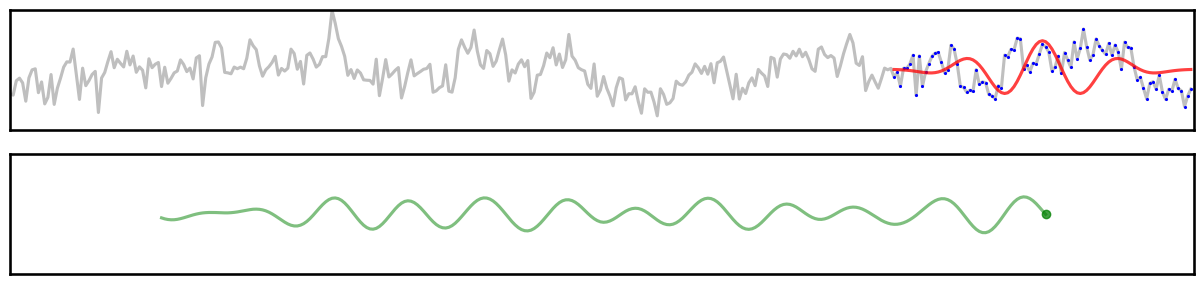

In [22]:
# Run the filter viz
build_convolution(sig, filt_coefs*1.5, 
                  save=SAVE, label='04-filter_aperiodic')

### Burst Signal

Visualize filter on a bursty signal.

In [23]:
# Simulate a bursty signal
n_cycles = 3
sine = sim_cycle(0.1, fs, 'sine')
burst = np.tile(sine, n_cycles)
burst_sig = np.zeros_like(sig)
index = int((len(burst_sig) / 2) - (len(burst) / 2))
burst_sig[index:index+len(burst)] = burst

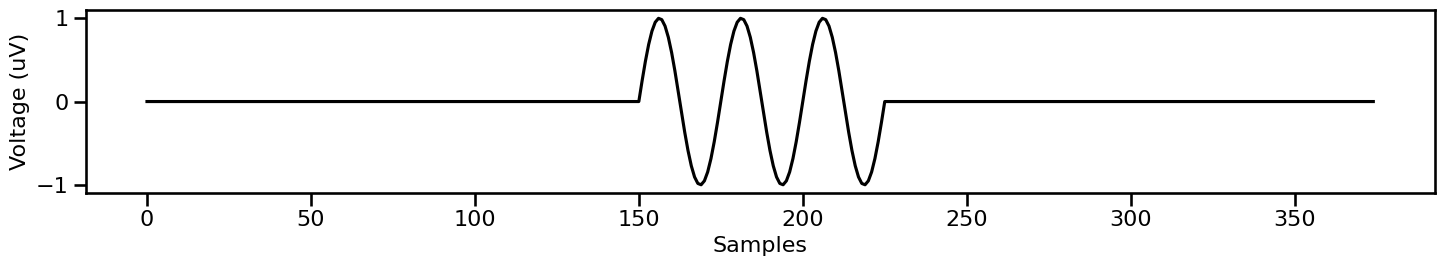

In [24]:
# Check the simulated burst signal
plot_time_series(None, burst_sig)

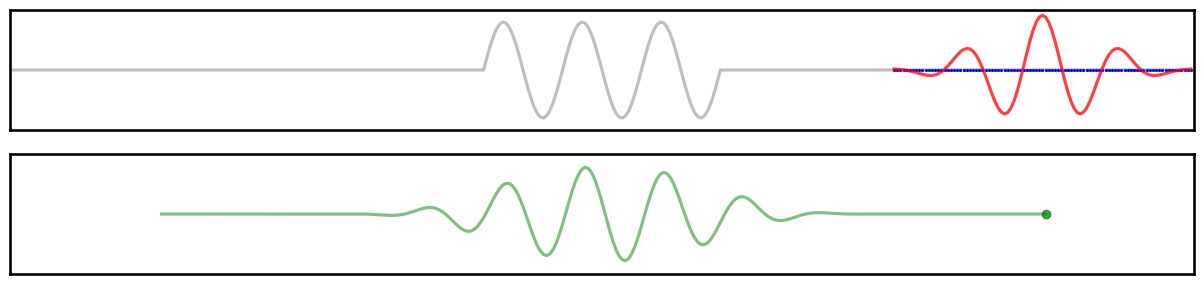

In [25]:
# Run the filter viz
build_convolution(burst_sig, filt_coefs, ylim=[-1.25, 1.25], 
                  save=SAVE, label='04-filter_burst')

## Filter Property Animations

Explore filter properties (impulse response & frequency response), across:
- across frequency ranges
- across across filter orders (lengths / n_cycles)

In [26]:
# Reset signal settings
fs = 1000

In [27]:
# Reset filter settings
pass_type = 'bandpass'
f_range = (8, 12)
n_cycles = 3

### Filter Properties

In [28]:
# Create new filter coefficients
filt_coefs = design_fir_filter(fs, pass_type, f_range)

In [29]:
# Compute frequency response
f_db, db = compute_frequency_response(filt_coefs, 1, fs)

/Users/tom/opt/anaconda3/lib/python3.8/site-packages/neurodsp/plts/style.py:101: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


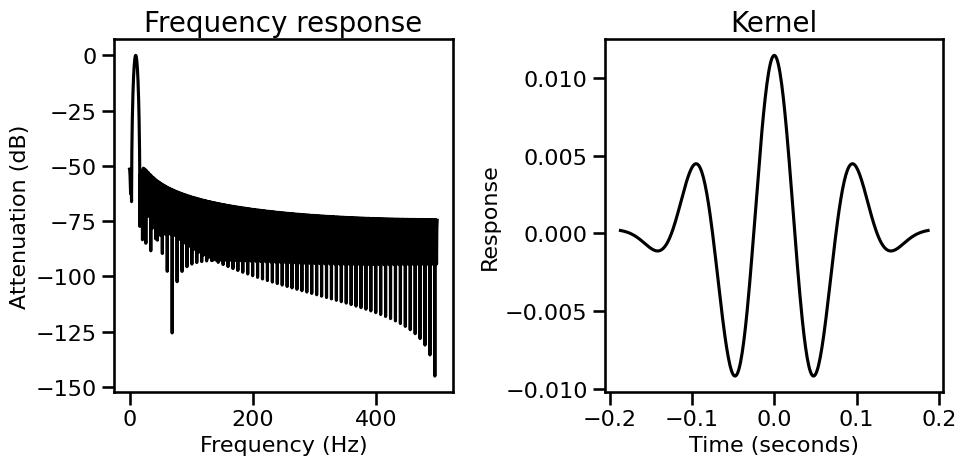

In [30]:
# Plot filter properties
plot_filter_properties(f_db, db, fs, filt_coefs)

#### Lowpass

In [31]:
# Settings
n_cycles = 5
pass_type = 'lowpass'
f_ranges = np.arange(100, 1, -2)

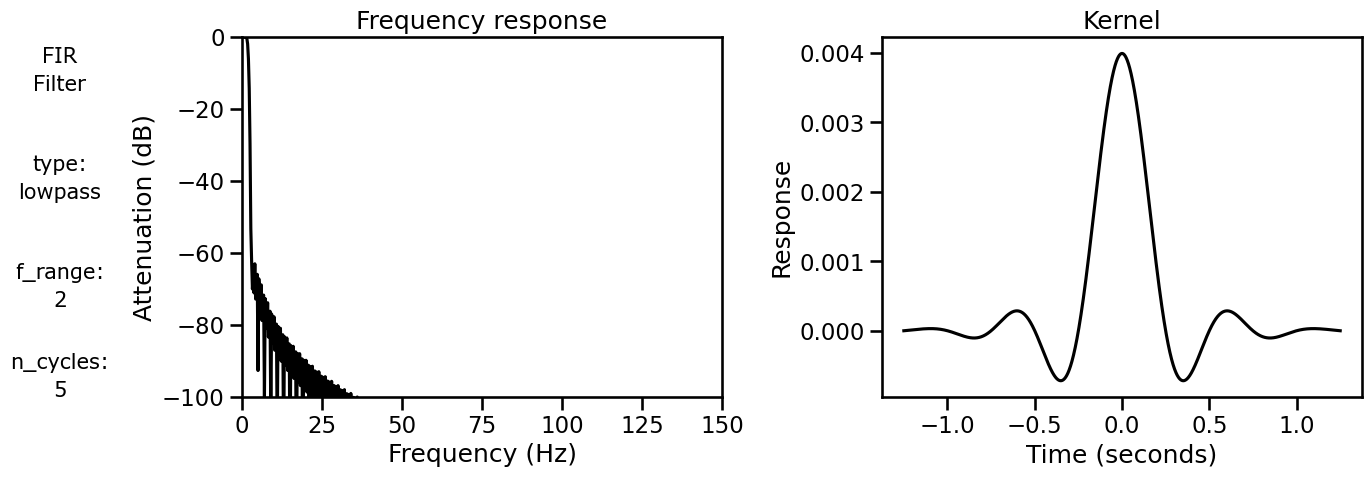

In [32]:
# Filter properties across lowpass frequency ranges
build_filter_properties(fs, pass_type, None, n_cycles, 'f_range', f_ranges,
                        save=SAVE, label='04-filtprop_lowpass_frange')

#### Highpass

In [33]:
# Settings
n_cycles = 5
pass_type = 'highpass'
f_ranges = np.arange(1, 100, 2)

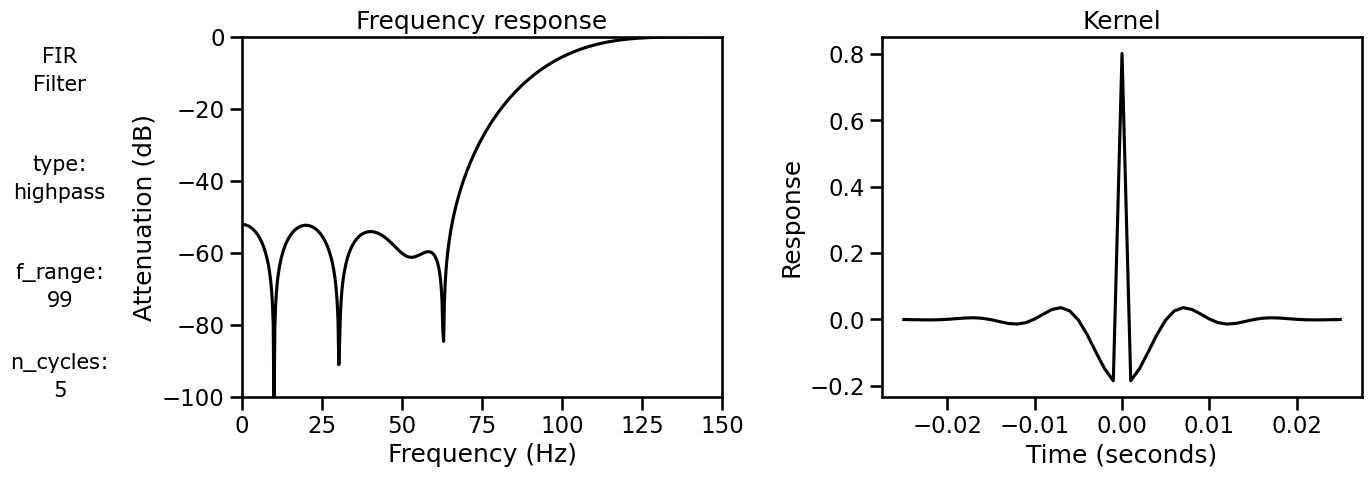

In [34]:
# Filter properties across highpass frequency ranges
build_filter_properties(fs, pass_type, None, n_cycles, 'f_range', f_ranges,
                        save=SAVE, label='04-filtprop_highpass_frange')

### Filter Length (n_cycles)

In [35]:
# Settings
pass_type = 'bandpass'
f_range = (8, 12)
inc = incrementer()
cycle_range = np.arange(1, 13)

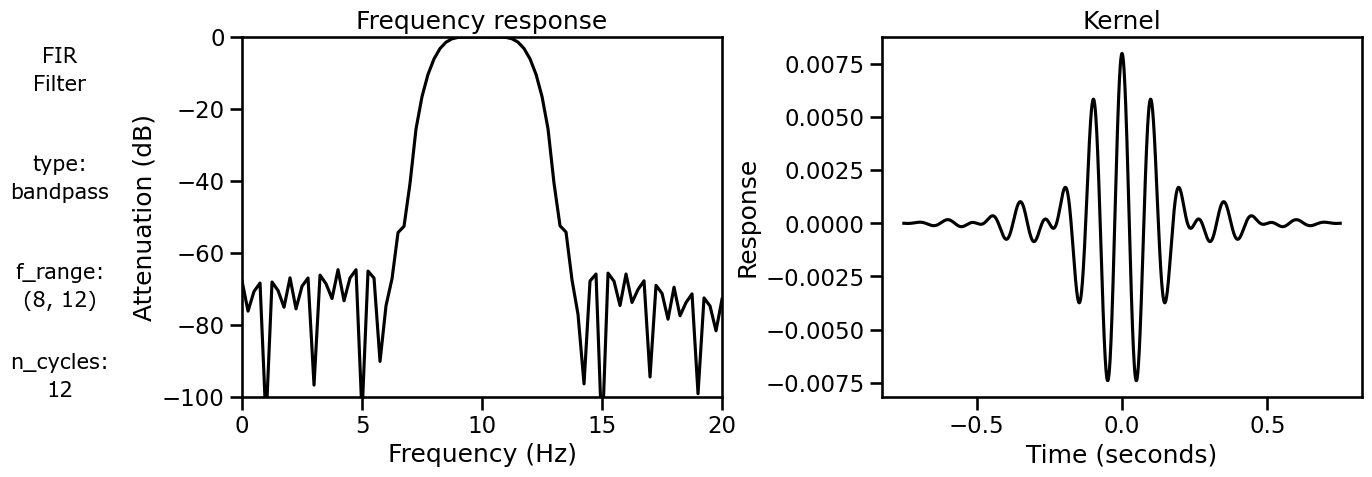

In [36]:
# Filter properties across number of cycles
build_filter_properties(fs, pass_type, f_range, None, 'n_cycles', cycle_range,
                        fr_xlim=[0, 20], save=SAVE, label='04-filtprop_ncycles')

### Filter Bandwidth

ToDo: change frequency response xrange

In [37]:
# Settings
pass_type = 'bandpass'
n_cycles = 5
cen = 20
bw_range = np.arange(0.5, 10, 0.5)

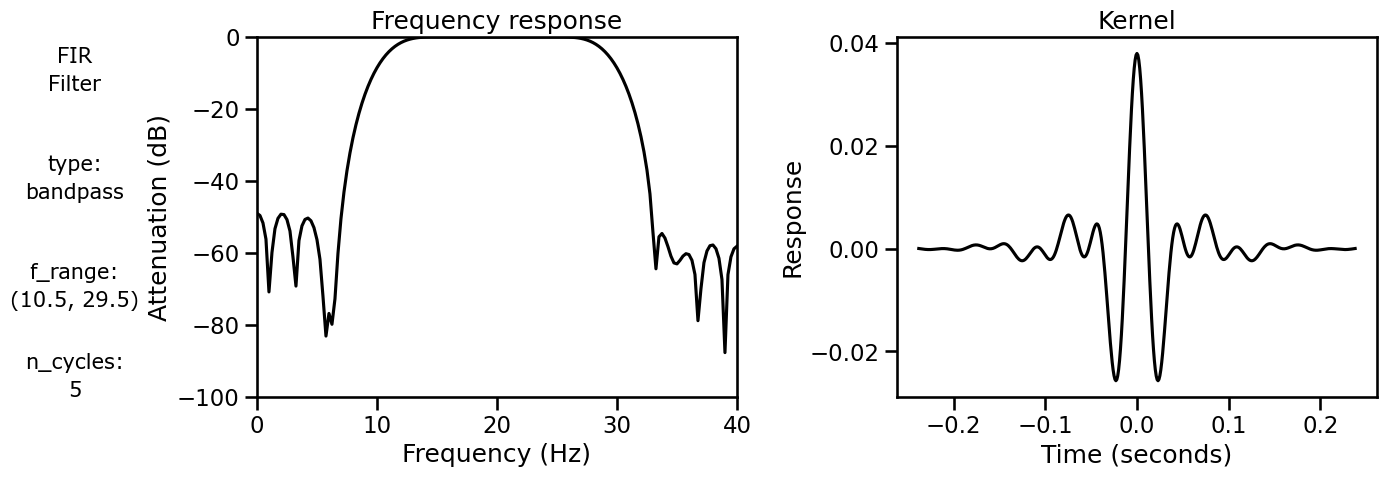

In [38]:
# Filter properties across filter bandwidth
build_filter_properties(fs, pass_type, cen, n_cycles, 'bandwidth', bw_range,
                        fr_xlim=[0, 40], save=SAVE, label='04-filtprop_bandpass')

## Filter Output Animations

In [39]:
# Reset settings
fs = 500
n_seconds = 2.1

In [40]:
# General settings
pass_type = 'bandpass'
f_range = (8, 12)
n_cycles = 3

In [41]:
# Define cycle range
cycle_range = np.arange(1, 13, 1)

# Define settings for varying filter bandwidth
cen = 10
bw_range = np.arange(1, 9)

#### Impulse Response

In [42]:
# Create an impulse response
impulse_sig = np.zeros(int(fs * n_seconds))
impulse_sig[int(len(impulse_sig)/2)] = 1

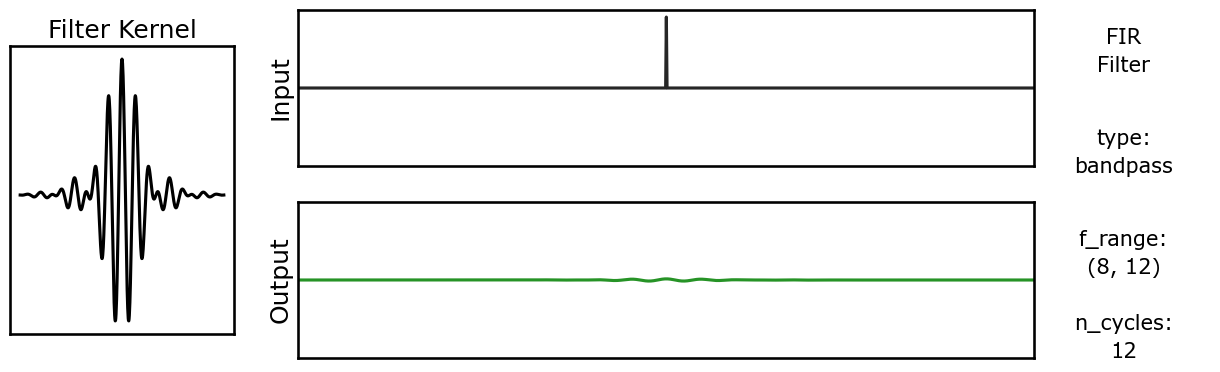

In [43]:
# Explore filter output on impulse response, across n_cycles
build_filter_ouput(impulse_sig, fs, pass_type, f_range, None, 'n_cycles', cycle_range,
                   save=SAVE, label='04-filtout_IR_ncycles')

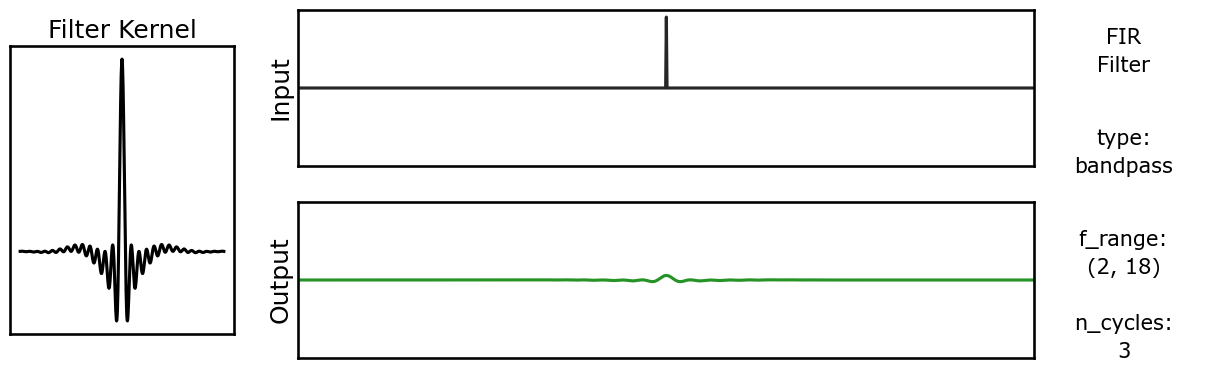

In [44]:
# Explore filter output on impulse response, across bandwidth
build_filter_ouput(impulse_sig, fs, pass_type, cen, n_cycles, 'bandwidth', bw_range,
                   save=SAVE, label='04-filtout_IR_bandwidth')

#### Step Signal

In [56]:
# Create a step signal
step_sig = np.zeros(int(fs * n_seconds))
#step_sig[int(len(impulse_sig)/2):] = 1
step_sig[int(len(impulse_sig)/3):2*int(len(impulse_sig)/3)] = 1

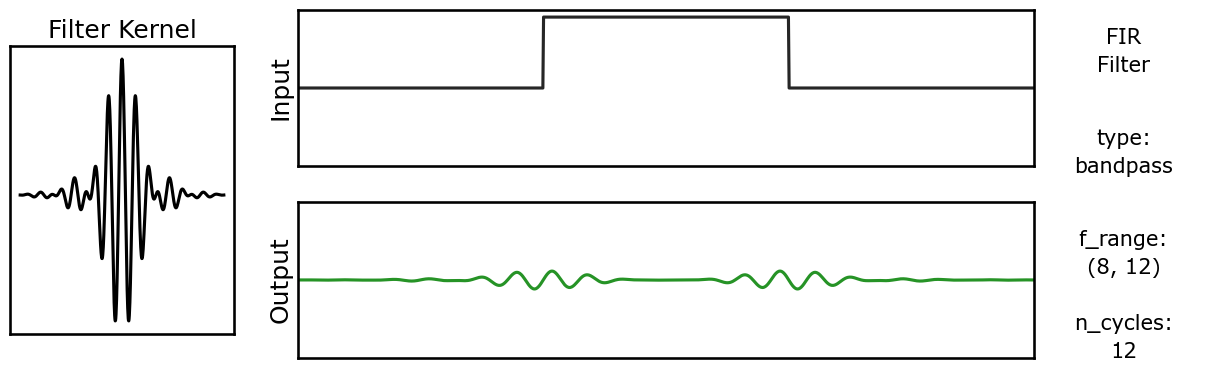

In [59]:
# Explore filter output on step function, across n_cycles
build_filter_ouput(step_sig, fs, pass_type, f_range, None, 'n_cycles', cycle_range,
                   save=SAVE, label='04-filtout_step_ncycles')

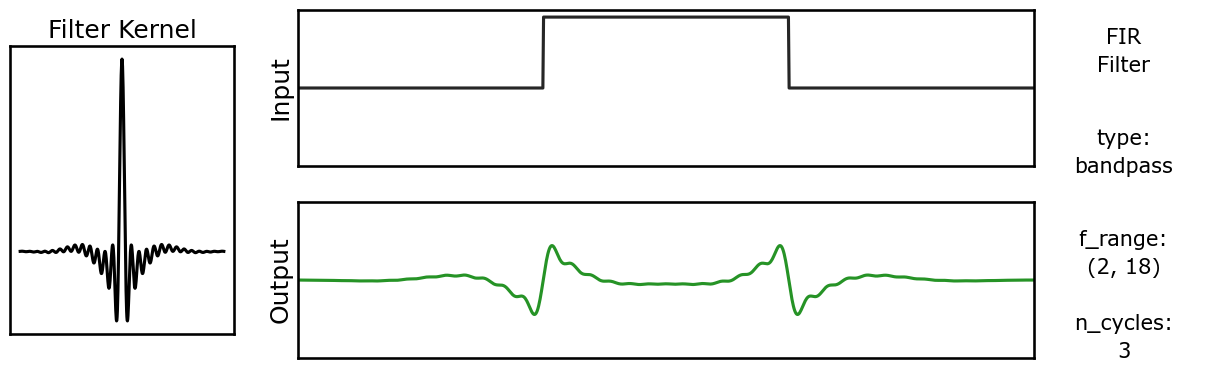

In [58]:
# Explore filter output on step function, across bandwidth
build_filter_ouput(step_sig, fs, pass_type, cen, n_cycles, 'bandwidth', bw_range,
                   save=SAVE, label='04-filtout_step_bandwidth')

#### Burst Signal

In [48]:
# Simulate a bursty signal
sine = sim_cycle(0.1, fs, 'sine')
n_burst_cycles = 3
burst = np.tile(sine, n_burst_cycles)
burst_sig = np.zeros(int(fs * n_seconds))
index = int((len(burst_sig) / 2) - (len(burst) / 2))
burst_sig[index:index+len(burst)] = burst

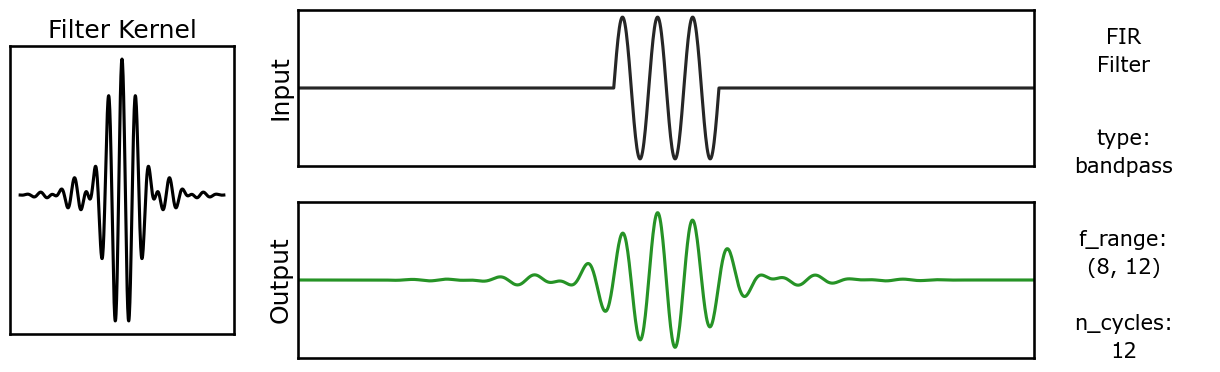

In [49]:
# Explore filter output on burst signal, across n_cycles
build_filter_ouput(burst_sig, fs, pass_type, f_range, None, 'n_cycles', cycle_range,
                   save=SAVE, label='04-filtout_burst_ncycles')

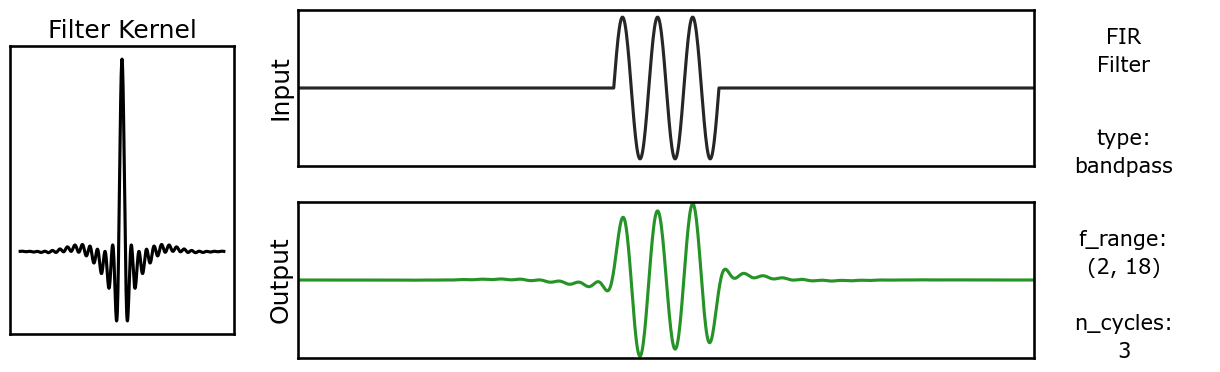

In [50]:
# Explore filter output on burst signal, across bandwidth
build_filter_ouput(burst_sig, fs, pass_type, cen, n_cycles, 'bandwidth', bw_range,
                   save=SAVE, label='04-filtout_burst_bandwidth')

#### Combined Signal

In [54]:
# Simulate a combined signal
comp_vars = [1, 0.5]
comps = {'sim_oscillation' : {'freq' : 10}, 
         'sim_powerlaw' : {'exponent' : -1, 'f_range' : (1, None)}}
sig = sim_combined(n_seconds, fs, comps, comp_vars, variance=0.15)

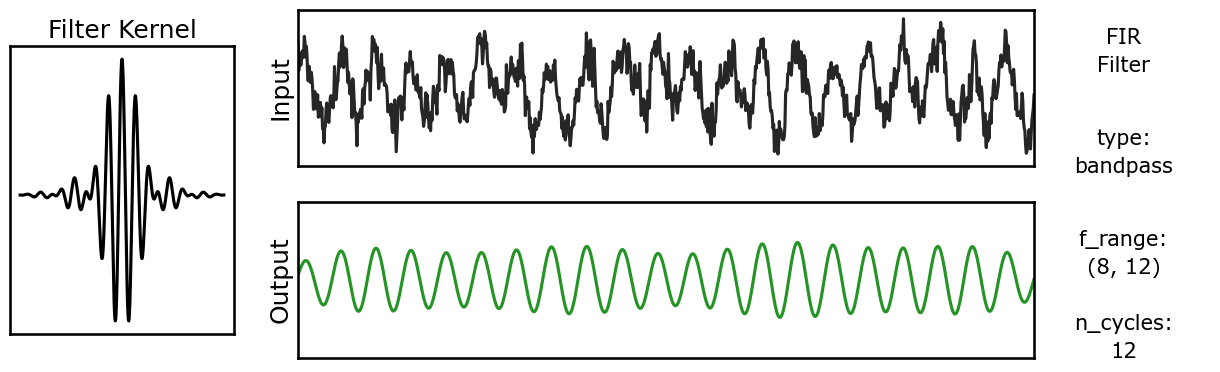

In [55]:
# Explore filter output on combined signal, across n_cycles
build_filter_ouput(sig, fs, pass_type, f_range, None, 'n_cycles', cycle_range,
                   save=SAVE, label='04-filtout_comb_ncycles')

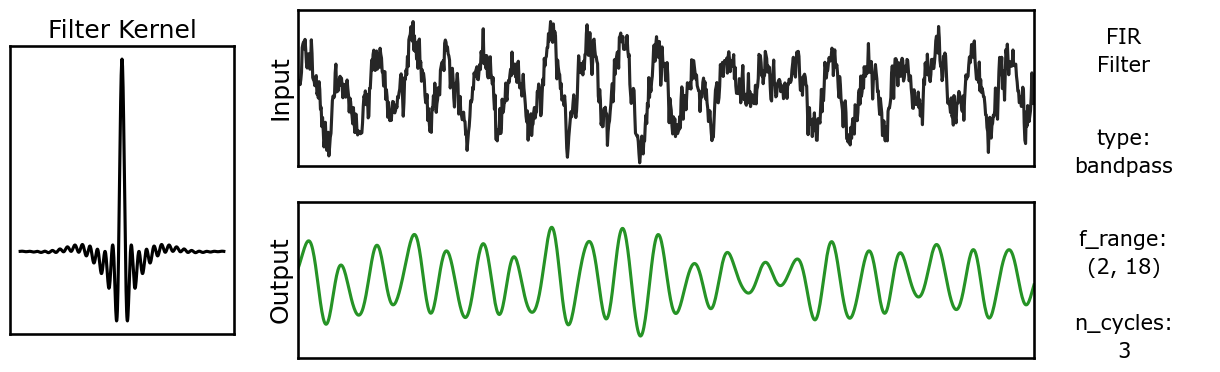

In [53]:
# Explore filter output on combined signal, across bandwidth
build_filter_ouput(sig, fs, pass_type, cen, n_cycles, 'bandwidth', bw_range,
                   save=SAVE, label='04-filtout_comb_bandwidth')